In [ ]:
!pip install --upgrade pip
!pip install fosforml numpy pandas matplotlib scikit-learn seaborn python-dateutil
!pip uninstall urllib3 -y
!pip install urllib3==1.26.15
!pip install fosforml 
!pip install fosforio
!pip install refractio
!pip install refractml

In [ ]:
!pip install seaborn scipy xgboost pandas dice-ml tabulate numpy scikit-learn pandas-profiling plotly matplotlib scipy statsmodels seaborn pydantic-settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from scipy.stats.mstats import winsorize
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import joblib
from fosforml import *
from fosforml.constants import MLModelFlavours
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [2]:
from refractio import snowflake
snowflake.get_connection(connection_name="HR_Attrition_Data")

Connection manager service url initialised to http://fdc-project-manager:80/project-manager
If you need to update its value then update the variable CONNECTION_MANAGER_BASE_URL in os env.
Exception occurred in getting snowflake connection: 'connectionSources'


In [3]:
df = snowflake.get_dataframe("HR_Attrition_Data")
df

,EMPLOYEE_ID,SALARY,JOB_SATISFACTION,PERCENTAGE_SALARY_HIKE,PERFORMANCE_RATING,OVER_TIME,RELATIONSHIP_SATISFACTION,CHURN,MAPPED_ROLE_CLEAN,HOSPITAL_TYPE,...,JOB_STARTDATE,JOB_ENDDATE,BIRTH_YEAR,AGE,SENIORITY,OVERTIME_HOURS,WORK_LIFE_BALANCE,BUSINESS_TRAVEL,ENVIRONMENT_SATISFACTION,USER_ID
0,94215814,53239.07,Low,11,Excellent,True,Medium,1,nurse,Acute Care Hospitals,...,2016-11-01,2017-06-01,1965,59,4,13,Best,Travel_Rarely,High,147501806
1,20227353,29277.97,Medium,11,Outstanding,False,Low,1,nurse,Acute Care Hospitals,...,2015-07-01,2016-06-01,1993,31,1,15,Good,Travel_Rarely,High,46143395
2,72815065,43763.54,Medium,18,Excellent,True,Medium,1,technologist,Acute Care Hospitals,...,2010-07-01,2012-05-01,1985,39,2,0,Better,Travel_Rarely,High,567514867
3,15048356,24728.57,Medium,12,Low,False,Very High,0,nurse,Acute Care Hospitals,...,2014-05-01,2015-09-01,1992,32,1,9,Good,Travel_Rarely,Very High,65551252
4,91151756,46819.01,Low,19,Good,False,Low,0,technologist,Acute Care Hospitals,...,2009-06-01,None,1983,41,2,13,Bad,Travel_Rarely,Very High,84119911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,11954788,30934.15,Medium,14,Excellent,True,Medium,1,nurse,Psychiatric,...,2019-09-01,2020-02-01,1996,28,1,2,Best,Travel_Rarely,Low,163926894
299996,65800600,69288.47,Medium,18,Good,True,Very High,1,nurse,Acute Care Hospitals,...,2019-04-01,2020-02-01,1996,28,2,3,Best,Travel_Rarely,Low,313934824
299997,78774518,53051.71,High,20,Outstanding,False,Low,0,emt,Acute Care Hospitals,...,2018-12-01,None,1991,33,1,8,Best,Travel_Rarely,High,812455262
299998,53352261,72186.39,Low,23,Low,False,Very High,0,technologist,Acute Care Hospitals,...,2020-09-01,None,1995,29,2,9,Best,Travel_Rarely,Medium,713192325


In [4]:
print(df.isnull().sum())

EMPLOYEE_ID                      0
SALARY                           0
JOB_SATISFACTION                 0
PERCENTAGE_SALARY_HIKE           0
PERFORMANCE_RATING               0
OVER_TIME                        0
RELATIONSHIP_SATISFACTION        0
CHURN                            0
MAPPED_ROLE_CLEAN                0
HOSPITAL_TYPE                    0
HOSPITAL_OWNERSHIP               0
COMPANY_NAME                     0
CITY                             0
STATE                            0
DISTANCE                         0
DEGREE_CLEAN                     0
SEX                              0
ETHNICITY                        0
MARITAL_STATUS                   0
TENURE_MONTHS                    0
MONTHS_AFTER_COLLEGE             0
SCHOOL_ENDDATE                   0
JOB_STARTDATE                    0
JOB_ENDDATE                  90076
BIRTH_YEAR                       0
AGE                              0
SENIORITY                        0
OVERTIME_HOURS                   0
WORK_LIFE_BALANCE   

In [5]:
Original_df = df.dropna()

In [6]:
print(Original_df.isnull().sum())

EMPLOYEE_ID                  0
SALARY                       0
JOB_SATISFACTION             0
PERCENTAGE_SALARY_HIKE       0
PERFORMANCE_RATING           0
OVER_TIME                    0
RELATIONSHIP_SATISFACTION    0
CHURN                        0
MAPPED_ROLE_CLEAN            0
HOSPITAL_TYPE                0
HOSPITAL_OWNERSHIP           0
COMPANY_NAME                 0
CITY                         0
STATE                        0
DISTANCE                     0
DEGREE_CLEAN                 0
SEX                          0
ETHNICITY                    0
MARITAL_STATUS               0
TENURE_MONTHS                0
MONTHS_AFTER_COLLEGE         0
SCHOOL_ENDDATE               0
JOB_STARTDATE                0
JOB_ENDDATE                  0
BIRTH_YEAR                   0
AGE                          0
SENIORITY                    0
OVERTIME_HOURS               0
WORK_LIFE_BALANCE            0
BUSINESS_TRAVEL              0
ENVIRONMENT_SATISFACTION     0
USER_ID                      0
dtype: i

In [ ]:
df = Original_df.drop(["USER_ID", "EMPLOYEE_ID", "JOB_STARTDATE", "JOB_ENDDATE", "SCHOOL_ENDDATE"], axis = 1)

In [9]:
CATEGORICAL_COLUMNS = ["MAPPED_ROLE_CLEAN","SEX", "ETHNICITY","HOSPITAL_TYPE", "HOSPITAL_OWNERSHIP","COMPANY_NAME","CITY","STATE","DISTANCE", 
                       "DEGREE_CLEAN","BUSINESS_TRAVEL","ENVIRONMENT_SATISFACTION","JOB_SATISFACTION","MARITAL_STATUS","OVER_TIME","PERFORMANCE_RATING","RELATIONSHIP_SATISFACTION","WORK_LIFE_BALANCE"]
NUMERICAL_COLUMNS = ["SALARY", "SENIORITY", "TENURE_MONTHS", "MONTHS_AFTER_COLLEGE", "BIRTH_YEAR","AGE","OVERTIME_HOURS","PERCENTAGE_SALARY_HIKE"]
LABEL_COLUMNS = ["CHURN"]
DROPPED_COLUMNS = ["USER_ID", "EMPLOYEE_ID", "JOB_STARTDATE", "JOB_ENDDATE", "SCHOOL_ENDDATE"]
OUTPUT_COLUMNS = ["PREDICTION"]

In [10]:
# Filter feature columns
feature_columns = CATEGORICAL_COLUMNS + NUMERICAL_COLUMNS
feature_columns = [col for col in feature_columns if col in df.columns]
LABEL_COLUMNS = [col for col in LABEL_COLUMNS if col in df.columns]
 
# Split data into features and labels
X = df[feature_columns + DROPPED_COLUMNS]
y = df[LABEL_COLUMNS].values.ravel()  # Flatten to 1D array for consistency

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
 
# Define transformers
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
)
 
numerical_transformer = make_pipeline(
    SimpleImputer(strategy='mean'),
    MinMaxScaler(clip=True)
)
 
# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, CATEGORICAL_COLUMNS),
        ('num', numerical_transformer, NUMERICAL_COLUMNS)
    ]
)
 
# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

pipeline.fit(X_train, y_train)
result = pipeline.predict(X_test)

In [14]:
result

array([1, 1, 0, ..., 0, 1, 0])

In [15]:
from joblib import dump, load
filename = "HR_Attrition.joblib"
dump(pipeline, filename)

['HR_Attrition.joblib']

In [16]:
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)

In [17]:
from refractml import *

from refractml.constants import MLModelFlavours

In [18]:
@scoring_func
def score(model, request):
    payload_dict = request.json["payload"]
    data_json = eval(payload)
    data = pd.DataFrame([data_json])
    prediction = str(model.predict(data)[0])
    return prediction

In [20]:
import requests
import datetime
import pandas as pd 
payload = str(X_test.iloc[123].to_dict())
req = requests.Request()
req.json = {"payload": payload}

print(score(pipeline, req))

1


In [21]:
req.json

{'payload': "{'MAPPED_ROLE_CLEAN': 'nurse', 'SEX': 'M', 'ETHNICITY': 'Hispanic', 'HOSPITAL_TYPE': 'Psychiatric', 'HOSPITAL_OWNERSHIP': 'Voluntary non-profit - Private', 'COMPANY_NAME': 'Centene Corp.', 'CITY': 'Orlando', 'STATE': 'FL', 'DISTANCE': '5-10 miles', 'DEGREE_CLEAN': 'Associates Degree', 'BUSINESS_TRAVEL': 'Travel_Frequently', 'ENVIRONMENT_SATISFACTION': 'Low', 'JOB_SATISFACTION': 'Medium', 'MARITAL_STATUS': 'Divorced', 'OVER_TIME': False, 'PERFORMANCE_RATING': 'Excellent', 'RELATIONSHIP_SATISFACTION': 'High', 'WORK_LIFE_BALANCE': 'Better', 'SALARY': 41273.03, 'SENIORITY': 1, 'TENURE_MONTHS': 24, 'MONTHS_AFTER_COLLEGE': 39, 'BIRTH_YEAR': 1994, 'AGE': 30, 'OVERTIME_HOURS': 7, 'PERCENTAGE_SALARY_HIKE': 17, 'USER_ID': 842947544, 'EMPLOYEE_ID': 22659757, 'JOB_STARTDATE': datetime.date(2020, 4, 1), 'JOB_ENDDATE': datetime.date(2022, 7, 1), 'SCHOOL_ENDDATE': datetime.date(2017, 1, 1)}"}

In [22]:
## registering the model in refract.
tmp = register_model(pipeline, 
               score, 
               name="HR_ATTRITION_ML_MODEL", 
               description="Analyzing_HR_Attrition_trained_using _ml",
               flavour=MLModelFlavours.sklearn,
               model_type="classification",
               init_script="\\n pip install fosforml \\n pip install seaborn \\n pip install snowflake-connector-python[pandas] \\n pip install joblib==1.3.2 scikit-learn=1.3.2",
               y_true=y_test,
               y_pred=y_pred, 
               features=X_train.columns,
               labels=[0,1],
               input_type="json", 
               explain_ai=True,
               prob=y_prob,
               x_train=X_train, 
               x_test=X_test, 
               y_train=y_train,
               y_test=y_test,
               feature_names=X_train.columns.tolist(),
               original_features=X_train.columns.tolist(),
               feature_ids=X_train.columns,
               target_names=['NOT LEFT','LEFT'],
               kyd=True, kyd_score = True)


Calculating build time metrics

Progress: ██████████████████████████████████████████████████████████████████████ 100.0%


In [23]:
payload  = {"payload": X_test.iloc[0].to_dict()}
payload

{'payload': {'MAPPED_ROLE_CLEAN': 'emt',
  'SEX': 'M',
  'ETHNICITY': 'API',
  'HOSPITAL_TYPE': 'Childrens',
  'HOSPITAL_OWNERSHIP': 'Voluntary non-profit - Other',
  'COMPANY_NAME': 'Cleveland Clinic',
  'CITY': 'Cleveland',
  'STATE': 'OH',
  'DISTANCE': '5-10 miles',
  'DEGREE_CLEAN': 'Other',
  'BUSINESS_TRAVEL': 'Travel_Frequently',
  'ENVIRONMENT_SATISFACTION': 'Very High',
  'JOB_SATISFACTION': 'High',
  'MARITAL_STATUS': 'Single',
  'OVER_TIME': False,
  'PERFORMANCE_RATING': 'Low',
  'RELATIONSHIP_SATISFACTION': 'Low',
  'WORK_LIFE_BALANCE': 'Good',
  'SALARY': 44199.47,
  'SENIORITY': 2,
  'TENURE_MONTHS': 6,
  'MONTHS_AFTER_COLLEGE': 163,
  'BIRTH_YEAR': 1986,
  'AGE': 38,
  'OVERTIME_HOURS': 6,
  'PERCENTAGE_SALARY_HIKE': 19,
  'USER_ID': 344356384,
  'EMPLOYEE_ID': 61027530,
  'JOB_STARTDATE': datetime.date(2021, 8, 1),
  'JOB_ENDDATE': datetime.date(2022, 3, 1),
  'SCHOOL_ENDDATE': datetime.date(2008, 1, 31)}}

In [ ]:
headers={"Content-type":"application/json"}
url = "http://svc-32a60b58-45e6-42da-874a-1c703d935a77:5001/hrattritionmlmodel/e782fefe-2c69-4a1a-bdf2-4489e3f06da0/score"
data={"payload": payload}
response = requests.post(url, json=data, headers=headers) 
response.json()

In [24]:
result = pipeline.predict(X_test)
result_prob = pipeline.predict_proba(X_test)
pred_df = X_test.copy()
result = result
result_prob = result_prob
pred_df["PREDICTION"] = result
pred_df["PROB"] = result_prob[:, 1]

In [25]:
from sklearn.metrics import classification_report, log_loss, roc_auc_score
 
# Check lengths
print("Length of y_test:", len(y_test))
print("Length of y_pred:", len(y_pred))
 
# Print classification report
print(classification_report(y_test, y_pred))
 
# Calculate accuracy
accuracy = sum(y_test == y_pred) / len(y_test)
print("Accuracy:", accuracy)
 
# Calculate additional metrics
log_loss_value = log_loss(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob[:, 1])  # Assuming class 1 is the positive class
 
print("Log Loss:", log_loss_value)
print("ROC AUC Score:", roc_auc)

Length of y_test: 60000
Length of y_pred: 60000
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     39999
           1       0.86      0.70      0.77     20001

    accuracy                           0.86     60000
   macro avg       0.86      0.82      0.84     60000
weighted avg       0.86      0.86      0.86     60000

Accuracy: 0.8617333333333334
Log Loss: 0.30740485920308047
ROC AUC Score: 0.9310637670696529


In [26]:
log_loss(y_test,pred_df["PROB"] )

0.30740485920308047

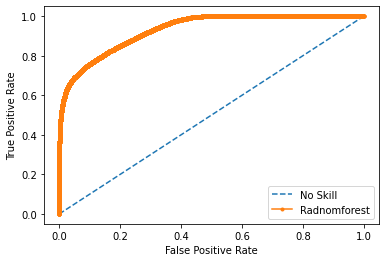

In [27]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
import seaborn as sns
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, pred_df["PROB"])
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, pred_df["PROB"])
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Radnomforest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

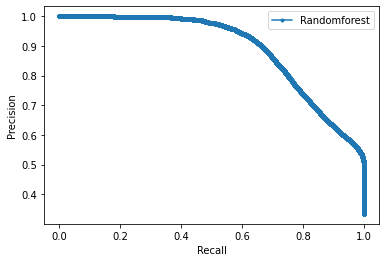

In [28]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, pred_df["PROB"])
plt.plot(lr_recall, lr_precision, marker='.', label='Randomforest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

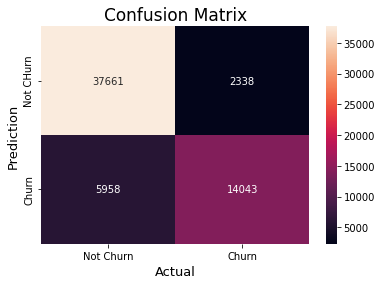

In [29]:
cm = confusion_matrix(y_test,y_pred)
 
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Not Churn','Churn'],
            yticklabels=['Not CHurn','Churn'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [30]:
scores_data = pd.DataFrame({"ns_probs":ns_probs,
                            "y_test":y_test,
                            "y_pred":pred_df["PREDICTION"],
                            "act_probs":pred_df["PROB"]})

In [31]:
scores_data

,ns_probs,y_test,y_pred,act_probs
4941,0,1,1,0.688668
51775,0,1,1,0.957386
115253,0,0,0,0.142907
299321,0,0,0,0.228895
173570,0,0,0,0.000138
...,...,...,...,...
75094,0,0,0,0.499123
171847,0,0,0,0.000083
138313,0,0,0,0.001382
271268,0,1,1,0.950559


In [32]:
scores_data.to_csv("/data/scores.csv", index=False)

In [33]:
print(f"Length of ns_probs: {len(ns_probs)}")
print(f"Length of y_pred: {len(pred_df['PREDICTION'])}")
print(f"Length of y_test_binary: {len(y_test)}")
print(f"Length of act_probs: {len(pred_df['PROB'])}")

Length of ns_probs: 60000
Length of y_pred: 60000
Length of y_test_binary: 60000
Length of act_probs: 60000


In [34]:
# Define or use the prediction function
def model_prediction_score_func(dataframe):
    # Ensure 'dataframe' has the correct features required by the model
    return pipeline.predict(dataframe)  # Use your trained pipeline/model here
 
# Assuming df is your input DataFrame with the necessary features
df['Model_Output'] = model_prediction_score_func(df)
 
# If you have a DataFrame with test data and you want to merge predictions
# Assuming X_test is the DataFrame for which predictions are made
X_test_with_predictions = X_test.copy()
X_test_with_predictions['Model_Output'] = model_prediction_score_func(X_test)
 
# Display the first few rows to verify
print(X_test_with_predictions.head())
 
# Optionally, save the combined DataFrame to a CSV file
X_test_with_predictions.to_csv("/data/combined_predictions.csv", index=False)

       MAPPED_ROLE_CLEAN SEX ETHNICITY         HOSPITAL_TYPE  \
4941                 emt   M       API             Childrens   
51775       occupational   F     Black  Acute Care Hospitals   
115253      technologist   M     White  Acute Care Hospitals   
299321             nurse   M  Multiple  Acute Care Hospitals   
173570             nurse   M  Multiple  Acute Care Hospitals   

                    HOSPITAL_OWNERSHIP  \
4941      Voluntary non-profit - Other   
51775   Voluntary non-profit - Private   
115253  Voluntary non-profit - Private   
299321    Voluntary non-profit - Other   
173570  Voluntary non-profit - Private   

                                            COMPANY_NAME        CITY STATE  \
4941                                    Cleveland Clinic   Cleveland    OH   
51775                             Encompass Health Corp.  Morgantown    WV   
115253                                  Cleveland Clinic   Cleveland    OH   
299321                             SSM Health Care

In [39]:
# Display the first few rows to verify
print(X_test_with_predictions.head())

       MAPPED_ROLE_CLEAN SEX ETHNICITY         HOSPITAL_TYPE  \
4941                 emt   M       API             Childrens   
51775       occupational   F     Black  Acute Care Hospitals   
115253      technologist   M     White  Acute Care Hospitals   
299321             nurse   M  Multiple  Acute Care Hospitals   
173570             nurse   M  Multiple  Acute Care Hospitals   

                    HOSPITAL_OWNERSHIP  \
4941      Voluntary non-profit - Other   
51775   Voluntary non-profit - Private   
115253  Voluntary non-profit - Private   
299321    Voluntary non-profit - Other   
173570  Voluntary non-profit - Private   

                                            COMPANY_NAME        CITY STATE  \
4941                                    Cleveland Clinic   Cleveland    OH   
51775                             Encompass Health Corp.  Morgantown    WV   
115253                                  Cleveland Clinic   Cleveland    OH   
299321                             SSM Health Care

In [41]:
print(f"Length of ns_probs: {len(ns_probs)}")
print(f"Length of y_pred: {len(pred_df['PREDICTION'])}")
print(f"Length of y_test_binary: {len(y_test)}")
print(f"Length of act_probs: {len(pred_df['PROB'])}")

Length of ns_probs: 60000
Length of y_pred: 60000
Length of y_test_binary: 60000
Length of act_probs: 60000


In [42]:
# Display the first few rows to verify
print(X_test_with_predictions.head())

       MAPPED_ROLE_CLEAN SEX ETHNICITY         HOSPITAL_TYPE  \
4941                 emt   M       API             Childrens   
51775       occupational   F     Black  Acute Care Hospitals   
115253      technologist   M     White  Acute Care Hospitals   
299321             nurse   M  Multiple  Acute Care Hospitals   
173570             nurse   M  Multiple  Acute Care Hospitals   

                    HOSPITAL_OWNERSHIP  \
4941      Voluntary non-profit - Other   
51775   Voluntary non-profit - Private   
115253  Voluntary non-profit - Private   
299321    Voluntary non-profit - Other   
173570  Voluntary non-profit - Private   

                                            COMPANY_NAME        CITY STATE  \
4941                                    Cleveland Clinic   Cleveland    OH   
51775                             Encompass Health Corp.  Morgantown    WV   
115253                                  Cleveland Clinic   Cleveland    OH   
299321                             SSM Health Care

In [ ]:
snowflake.execute_query(f"PUT file://data/combined_predictions.csv @HR_ANALYTIC.HR_ATTRITION.HR_ANALYTICAL_DATA_ATTRITION_STAGE")

In [43]:
con = snowflake.get_connection("HR_Attrition_Data")

Exception occurred in getting snowflake connection: 'connectionSources'


In [44]:
file = 'HR_Attrition_Model_Data.csv'
X_test_with_predictions.to_csv(file , index=False)

In [45]:
file

'HR_Attrition_Model_Data.csv'

In [ ]:
snowflake.execute_query(f"PUT file://{file} @HR_ANALYTIC.HR_ATTRITION.HR_ANALYTICAL_DATA_ATTRITION_STAGE")

In [46]:
snowflake.execute_query(f"PUT file:// @HR_ANALYTIC.HR_ATTRITION.HR_ANALYTICAL_DATA_ATTRITION_STAGE")

User name picked from OS env: vishal.baldwa@fosfor.com
Fetching connections created by vishal.baldwa@fosfor.com user
Connection names fetched ['HR Attrition conn'], created by vishal.baldwa@fosfor.com
Connection object created: <snowflake.connector.connection.SnowflakeConnection object at 0x7f31842d2850>
Please close the connection after use!
Exception occurred in execute_query: 253006: Not a file but a directory: /notebooks/notebooks/
